<a href="https://colab.research.google.com/github/TIPJhonTellez/MODFLOW-2005/blob/cmake/Ejemplo_MODFLOW_con_flopy_usando_paquete_de_pozos_Documentado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Instalo flopy y pymake
!pip install git+https://github.com/modflowpy/pymake.git@90bcc5d48c758b73c10798968bda6b07ccec0009
!pip install flopy

#Importo las librerias
import pymake
import os
import numpy as np
import matplotlib.pyplot as plt
import flopy
import flopy.utils.binaryfile as bf
%matplotlib inline

#Compilo MODFLOW 2005 en linux
#pymake.build_apps('mt3dusgs')
pymake.build_apps('mf2005')

# Creo el la carpeta donde voy a trabajar la simulacion
workspace = '/content/'
if not os.path.exists(workspace):
    os.makedirs(workspace)
!realpath mf2005

# name - Nombre del modelo
modelname = "ejemplo_pozo"

# exe name - Nombre y direccion de MODFLOW 2005
exe_mf2005 = '/content/mf2005'

# Configuracion del inicial para modflow
mf = flopy.modflow.Modflow(
    modelname=modelname, 
    exe_name=exe_mf2005,
    model_ws=workspace
)

  Cloning https://github.com/modflowpy/pymake.git (to revision 90bcc5d48c758b73c10798968bda6b07ccec0009) to /tmp/pip-req-build-oro2wckv
  Running command git clone -q https://github.com/modflowpy/pymake.git /tmp/pip-req-build-oro2wckv
  Running command git rev-parse -q --verify 'sha^90bcc5d48c758b73c10798968bda6b07ccec0009'
  Running command git fetch -q https://github.com/modflowpy/pymake.git 90bcc5d48c758b73c10798968bda6b07ccec0009
  Running command git checkout -q 90bcc5d48c758b73c10798968bda6b07ccec0009
  Created wheel for pymake: filename=pymake-1.1.0-py3-none-any.whl size=37975 sha256=b9a3b9eea30748a77529c0502f46f512251daa3e70118e3f771e6e48558bcd84
  Stored in directory: /root/.cache/pip/wheels/7d/b0/47/d42e520d45212d230dd2f8d55b265ee4434235a001fe054a91
Successfully built pymake
     |████████████████████████████████| 1.2 MB 5.0 MB/s 
  Created wheel for flopy: filename=flopy-3.3.4-py3-none-any.whl size=1230396 sha256=ea3ebe2b19ded4450bf7445cbbc063f8f9339410f6f4555d88fe7aae2eb61a

In [ ]:
# Definicion de las celdas y dominio del modelo
Lx = 1000.
Ly = 1000.
ztop = 100.
zbot = -100.

#Discretizacion espaciol del modelo
nlay = 4 #numero de capas
nrow = 10 #numero de filas
ncol = 10 #numero de columnas
delr = Lx/ncol # Define el espaciado entre las columnas
delc = Ly/nrow # Define el espaciado entre las filas
delv = (ztop - zbot) / nlay # Define el espaciado entre las capas
botm = np.linspace(ztop, zbot, nlay + 1) # Matriz de la elevacion de fondo

#Discretizacion del tiempo
nper = 4 # Numero de periodos de tiempo
perlen = [2.0, 3.0, 4.0, 3.0] # Periodos de tiempo en dias
perlen = [x * 86400 for x in perlen]  # Dia a segundos
nstp = [3,1,2,1] # Numero de pasos de tiempo en cada periodo de estres
steady=False # Indica si el perido de stress es estacionario o no 

#Sistema de unidades 

itmuni=1 # (0 - undefined, 1 – seconds, 2 – minutes, 3 - hours,  4 - days,  5 - years)
lenuni=2 # (0 - undefined, 1 - feet, 2 - meters, 3 - centimeters)

In [ ]:
# Crear el objeto de discretizacion
dis = flopy.modflow.ModflowDis(mf,  # Modelo
                               nlay, nrow, ncol, delr=delr, delc=delc, 
                               top=ztop, botm=botm[1:], 
                               nper=nper, perlen=perlen, nstp=nstp, steady=False,
                               itmuni=1, lenuni=2) #unidades de tiempo y de medidas

# Parametros por defecto del paquete de discretizacion
# classModflowDis(model, nlay=1, nrow=2, ncol=2, nper=1, delr=1.0, delc=1.0, laycbd=0,
#                  top=1, botm=0, perlen=1, nstp=1, tsmult=1, steady=True, itmuni=4, 
#                  lenuni=2, extension='dis', unitnumber=None, filenames=None, xul=None, yul=None, 
#                  rotation=None, proj4_str=None, start_datetime=None)

In [ ]:
# Variables para el paquete BAS (Basico) 
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32) #Variable Ibound
ibound[0, :, 0] = -1
ibound[0, :, -1] = -1
strt = np.ones((nlay, nrow, ncol), dtype=np.float32) # Variable con las cabezas iniciales
strt[0, :, 0] = 100.
strt[0, :, -1] = 80.

# Configuracion del paquete basico
bas = flopy.modflow.ModflowBas(mf,  # Modelo
                               ibound=ibound, 
                               strt=strt) 

#Parametros por defecto del paquete basico
#classModflowBas(model, ibound=1, strt=1.0, ifrefm=True, ixsec=False, 
#                ichflg=False, stoper=None, hnoflo=-999.99, extension='bas', 
#                unitnumber=None, filenames=None)

In [ ]:
# Configuracion del paquete de pozos

# Diccionario de límites Cada pozo se define mediante la definición de layer (int), row (int), column (int), flux (float).
sp_data = {0:[2, 6, 6, -0.01], 1:[2, 6, 6, -0.025], 2:[2, 6, 6, -0.036], 3:[2, 6, 6, 0.036]}

wel1 = flopy.modflow.ModflowWel(mf, stress_period_data=sp_data)

# Parametros del paquete de pozos
# class ModflowWel(model, ipakcb=None, stress_period_data=None, dtype=None, 
#                 extension='wel', options=None, binary=False, unitnumber=None, 
#                 filenames=None)

In [ ]:
# Paquete Layer-Property Flow LPF
lpf = flopy.modflow.ModflowLpf(mf, #Modelo
                               hk=2e-5,  # conductividad hidráulica a lo largo de las filas
                               vka=2e-5) # conductividad hidráulica vertical

# Parametros del paquete LPF
# classModflowLpf(model, laytyp=0, layavg=0, chani=1.0, layvka=0, laywet=0, 
#                 ipakcb=None, hdry=-1e+30, iwdflg=0, wetfct=0.1, iwetit=1, 
#                 ihdwet=0, hk=1.0, hani=1.0, vka=1.0, ss=1e-05, sy=0.15, 
#                 vkcb=0.0, wetdry=-0.01, storagecoefficient=False, constantcv=False, 
#                 thickstrt=False, nocvcorrection=False, novfc=False, extension='lpf', 
#                 unitnumber=None, filenames=None)

In [ ]:
# Diccionario para cada lista de opciones de guardado. Si stress_period_data es None, entonces las cabezas se guardan para el último paso de cada período de estres
stressperioddata={(0,2):['save head'],(1,0):['save head'],(2,1):['save head'],(3,0):['save head']}

# Paquete Output Control OC 
oc = flopy.modflow.ModflowOc(mf, stress_period_data=stressperioddata)

#Parametros del paquete OC
# classModflowOc(model, ihedfm=0, iddnfm=0, chedfm=None, cddnfm=None, cboufm=None, 
#               compact=True, stress_period_data={(0, 0): ['save head']}, 
#               extension=['oc', 'hds', 'ddn', 'cbc', 'ibo'], unitnumber=None, 
#               filenames=None, label='LABEL', **kwargs)

In [ ]:
# Paquete Solver PCG
pcg = flopy.modflow.ModflowPcg(mf)

# Parametros del paquete PCG Solver
# classModflowPcg(model, mxiter=50, iter1=30, npcond=1, hclose=1e-05, rclose=1e-05, 
#                 relax=1.0, nbpol=0, iprpcg=0, mutpcg=3, damp=1.0, dampt=1.0, 
#                 ihcofadd=0, extension='pcg', unitnumber=None, filenames=None)

In [ ]:
# Creamos los input files de MODFLOW
mf.write_input()

In [ ]:
# Ejecutamos el modelo en MODFLOW
success, buff = mf.run_model()

FloPy is using the following executable to run the model: /content/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ejemplo_pozo.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2021/12/06 18:39:02

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2021/12/06 18:39:02


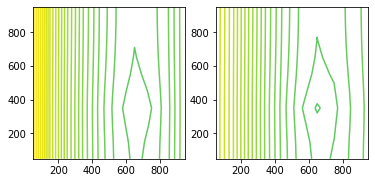

In [ ]:
#Grafica de la simulacion

import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf

totaltimes = np.cumsum(perlen)

plt.subplot(1,2,1,aspect='equal')
hds = bf.HeadFile(os.path.join(workspace,modelname+'.hds'))# parametros del headfile y las series de tiempo 
head = hds.get_data(totim=totaltimes[0]) #Trae los datos del archivo binario
levels = np.arange(0,100,1)
extent = (delr/2., Lx - delr/2., Ly - delc/2., delc/2.)
plt.contour(head[0, :, :], levels=levels, extent=extent)


plt.subplot(1,2,2,aspect='equal')
hds = bf.HeadFile(os.path.join(workspace,modelname+'.hds'))
head = hds.get_data(totim=totaltimes[0])
levels = np.arange(0,100,1)
extent = (delr/2., Lx - delr/2., Ly - delc/2., delc/2.)
plt.contour(head[3, :, :], levels=levels, extent=extent)
plt.show()

In [ ]:
import shutil
shutil.copyfile(os.path.join(workspace,modelname+'.hds'),os.path.join(workspace,modelname+'.bhd'))

'/content/ejemplo_pozo.bhd'